In [167]:
# figure out if I should do an import block or import just in time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats
import env
import acquire
import os

# turn off pink boxes for demo
import warnings
warnings.filterwarnings("ignore")

In [27]:
# change setting to show all columns
pd.set_option('display.max_columns', None)

# Title

Lori Ainslie, 11/29/21

# Executive Summary

## Project Goals

- To identify drivers of customer churn and find a solution for increasing customer retention

- To construct a model that accurately predicts which customers are most likely to churn to focus retention efforts

## Project Description

why you are tackling this project, why it is important and how it could be of use to someone else beyond just the interest or new knowledge.

## Acquisition

Include SQL query if not too long

In [178]:
# pull in telco data
df = acquire.get_telco_data()

In [179]:
# pull in telco data & check out what first few rows look like
df = get_telco_data()
df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,No phone service,Yes,No,No,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,No phone service,Yes,Yes,Yes,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,4,1,3,0056-EPFBG,Male,0,Yes,Yes,20,No,No phone service,Yes,No,Yes,Yes,No,No,Yes,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,3,1,3,0078-XZMHT,Male,0,Yes,No,72,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


## Preparation

In [30]:
# check column names, shape, data types, null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [180]:
# check for outliers and get statistical information
df[['monthly_charges', 'total_charges']].describe()

,monthly_charges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [181]:
# change data type for total charges from string to float
df.total_charges = pd.to_numeric(df.total_charges, errors='coerce')

In [147]:
df.total_charges.dtype

dtype('float64')

In [182]:
# drop rows where new customers have not yet had opportunity to churn
df = df[df.total_charges.notnull()]
df.shape

(7032, 24)

In [150]:
# review column names
df.columns

Index(['payment_type_id', 'internet_service_type_id', 'contract_type_id',
       'customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'contract_type', 'internet_service_type',
       'payment_type'],
      dtype='object')

In [106]:
# check categorical column values
col_list = df.columns.tolist()
for col in col_list:
    if col not in ['customer_id', 'tenure', 'monthly_charges', 'total_charges']:
        print(df[col].value_counts(dropna=False))

1    2365
2    1604
3    1542
4    1521
Name: payment_type_id, dtype: int64
2    3096
1    2416
3    1520
Name: internet_service_type_id, dtype: int64
1    3875
3    1685
2    1472
Name: contract_type_id, dtype: int64
Male      3549
Female    3483
Name: gender, dtype: int64
0    5890
1    1142
Name: senior_citizen, dtype: int64
No     3639
Yes    3393
Name: partner, dtype: int64
No     4933
Yes    2099
Name: dependents, dtype: int64
Yes    6352
No      680
Name: phone_service, dtype: int64
No                  3385
Yes                 2967
No phone service     680
Name: multiple_lines, dtype: int64
No                     3497
Yes                    2015
No internet service    1520
Name: online_security, dtype: int64
No                     3087
Yes                    2425
No internet service    1520
Name: online_backup, dtype: int64
No                     3094
Yes                    2418
No internet service    1520
Name: device_protection, dtype: int64
No                     3472
Yes    

In [39]:
# check data
df.head()

,gender,senior_citizen,partner,dependents,tenure,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,Female,0,Yes,Yes,65,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,90.45,5957.90,No,Two year,DSL,Mailed check
1,Male,0,No,No,54,No phone service,Yes,No,No,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,Female,0,No,No,56,No phone service,Yes,Yes,Yes,Yes,No,No,No,45.05,2560.10,No,Two year,DSL,Bank transfer (automatic)
3,Male,0,Yes,Yes,20,No phone service,Yes,No,Yes,Yes,No,No,Yes,39.40,825.40,No,Two year,DSL,Credit card (automatic)
4,Male,0,Yes,No,72,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,85.15,6316.20,No,Two year,DSL,Bank transfer (automatic)


In [183]:
# replace information included in another column to create binary values and simplify encoding
df.replace('No internet service', 'No', inplace=True)
df.online_security.value_counts()

No     5017
Yes    2015
Name: online_security, dtype: int64

In [184]:
# create df of dummy variables for columns with two values, dropping first
dummy_df1 = pd.get_dummies(df[['gender', 'partner', 'dependents', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'paperless_billing', 'churn']], drop_first=True)

In [185]:
# create df of dummy variables for columns with more than two values, keeping all columns for clarity
dummy_df2 = pd.get_dummies(df[['multiple_lines','contract_type', 'internet_service_type', 'payment_type']])

In [154]:
df.columns

Index(['payment_type_id', 'internet_service_type_id', 'contract_type_id',
       'customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'contract_type', 'internet_service_type',
       'payment_type'],
      dtype='object')

In [186]:
# identify and drop columns that are unnecessary or duplicated
cols_to_drop = ['payment_type_id', 'internet_service_type_id', 'contract_type_id',
       'customer_id', 'gender','partner', 'dependents', 'phone_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'churn']
df = df.drop(columns=cols_to_drop)

In [187]:
# concatenate dummy variable dfs onto original dataframe
df = pd.concat([df, dummy_df1, dummy_df2], axis=1)

In [157]:
# check shape to see if changes were made
df.shape

(7032, 32)

In [158]:
df.head()

,senior_citizen,tenure,multiple_lines,monthly_charges,total_charges,contract_type,internet_service_type,payment_type,gender_Male,partner_Yes,dependents_Yes,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,multiple_lines_No,multiple_lines_No phone service,multiple_lines_Yes,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,0,65,Yes,90.45,5957.90,Two year,DSL,Mailed check,0,1,1,1,1,1,1,1,1,1,0,0,0,1,0,0,1,1,0,0,0,0,0,1
1,0,54,No phone service,45.20,2460.55,Two year,DSL,Credit card (automatic),1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0
2,0,56,No phone service,45.05,2560.10,Two year,DSL,Bank transfer (automatic),0,0,0,1,1,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0
3,0,20,No phone service,39.40,825.40,Two year,DSL,Credit card (automatic),1,1,1,1,0,1,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0
4,0,72,Yes,85.15,6316.20,Two year,DSL,Bank transfer (automatic),1,1,0,0,1,1,1,1,1,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0


In [159]:
# check column names
df.columns

Index(['senior_citizen', 'tenure', 'multiple_lines', 'monthly_charges',
       'total_charges', 'contract_type', 'internet_service_type',
       'payment_type', 'gender_Male', 'partner_Yes', 'dependents_Yes',
       'online_security_Yes', 'online_backup_Yes', 'device_protection_Yes',
       'tech_support_Yes', 'streaming_tv_Yes', 'streaming_movies_Yes',
       'paperless_billing_Yes', 'churn_Yes', 'multiple_lines_No',
       'multiple_lines_No phone service', 'multiple_lines_Yes',
       'contract_type_Month-to-month', 'contract_type_One year',
       'contract_type_Two year', 'internet_service_type_DSL',
       'internet_service_type_Fiber optic', 'internet_service_type_None',
       'payment_type_Bank transfer (automatic)',
       'payment_type_Credit card (automatic)', 'payment_type_Electronic check',
       'payment_type_Mailed check'],
      dtype='object')

In [188]:
# rename columns for clarity
df.rename(columns={
                'gender_Male': 'is_male',
                'partner_Yes': 'has_partner',
                'dependents_Yes': 'has_dependents',
                'online_security_Yes': 'online_security',
                'online_backup_Yes': 'online_backup',
                'device_protection_Yes': 'device_protection',
                'tech_support_Yes': 'tech_support',
                'streaming_tv_Yes': 'streaming_tv',
                'streaming_movies_Yes': 'streaming_movies',
                'paperless_billing_Yes': 'paperless_billing',
                'churn_Yes': 'churn',
                'multiple_lines_No': 'one_line',
                'multiple_lines_No phone service': 'no_phone_service',
                'multiple_lines_Yes': 'has_multiple_lines',
                'contract_type_Month-to-month': 'month_to_month_contract',
                'contract_type_One year': 'one_year_contract',
                'contract_type_Two year': 'two_year_contract',
                'internet_service_type_DSL': 'dsl_internet',
                'internet_service_type_Fiber optic': 'fiber_optic_internet',
                'internet_service_type_None': 'no_internet_service',
                'payment_type_Bank transfer (automatic)': 'bank_transfer_payment_automatic',
                'payment_type_Credit card (automatic)': 'credit_card_payment_automatic',
                'payment_type_Electronic check': 'electronic_check_payment',
                'payment_type_Mailed check': 'mailed_check_payment'}, inplace=True)

In [189]:
# check that changes were made
df.columns

Index(['senior_citizen', 'tenure', 'multiple_lines', 'monthly_charges',
       'total_charges', 'contract_type', 'internet_service_type',
       'payment_type', 'is_male', 'has_partner', 'has_dependents',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'paperless_billing', 'churn',
       'one_line', 'no_phone_service', 'has_multiple_lines',
       'month_to_month_contract', 'one_year_contract', 'two_year_contract',
       'dsl_internet', 'fiber_optic_internet', 'no_internet_service',
       'bank_transfer_payment_automatic', 'credit_card_payment_automatic',
       'electronic_check_payment', 'mailed_check_payment'],
      dtype='object')

In [190]:
# specify numerical columns
num_cols = ['senior_citizen', 'multiple_lines', 'contract_type', 'internet_service_type',
       'payment_type', 'is_male', 'has_partner', 'has_dependents',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'paperless_billing', 'churn']

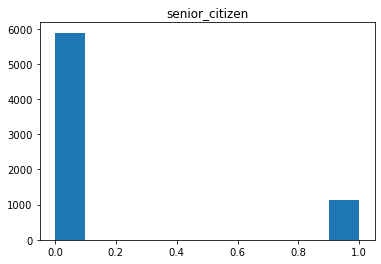

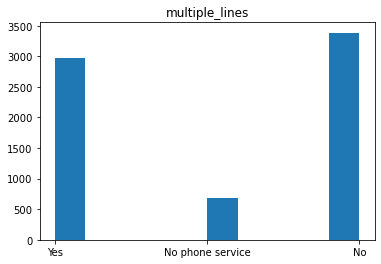

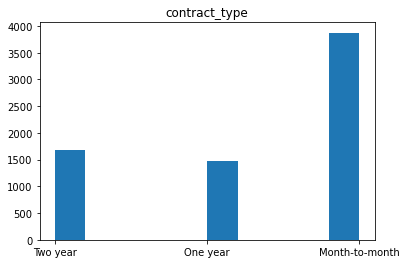

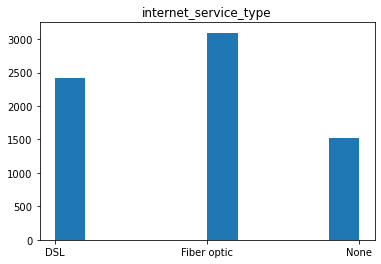

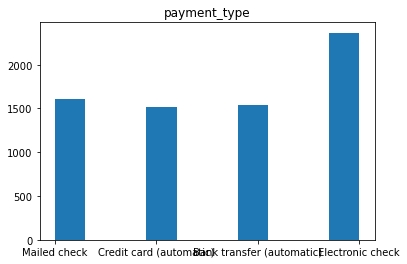

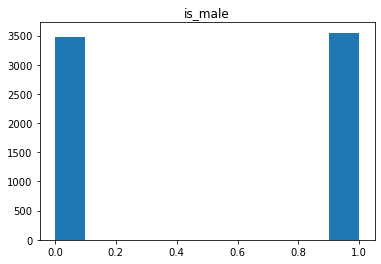

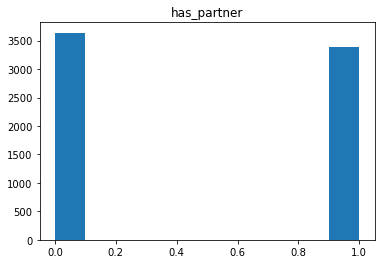

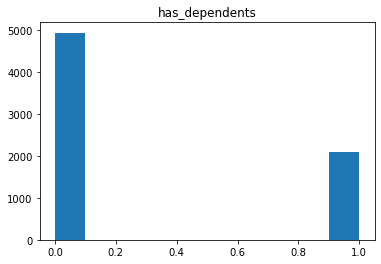

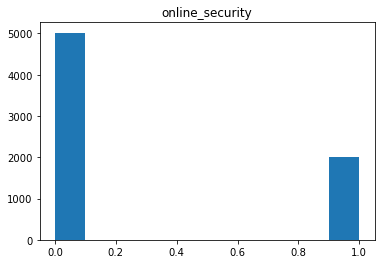

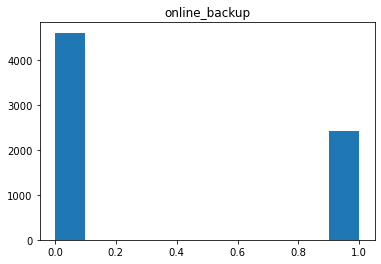

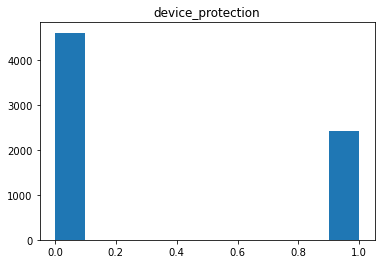

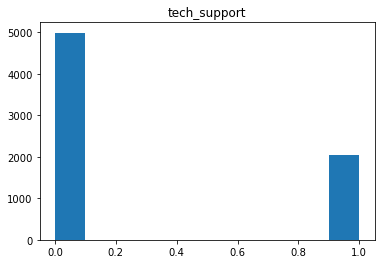

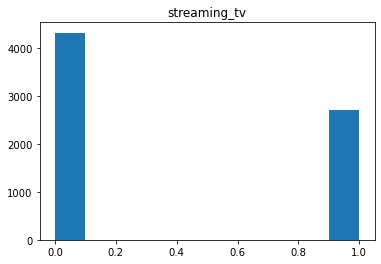

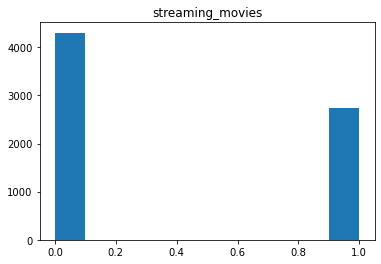

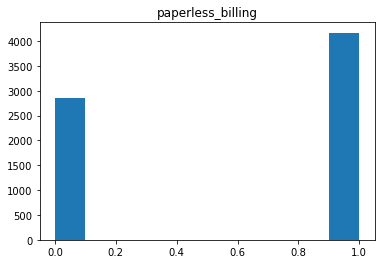

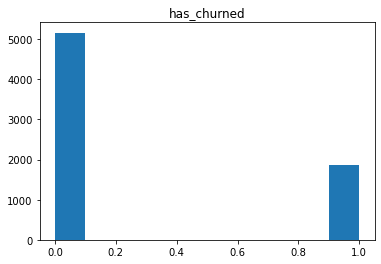

In [165]:
# create histogram for numerical columns to check out distribution
for col in num_cols: 
    plt.hist(df[col])
    plt.title(col)
    plt.show()

In [191]:
df.monthly_charges.value_counts(bins=5, normalize=True, sort=False)

(18.148999999999997, 38.35]    0.254693
(38.35, 58.45]                 0.142634
(58.45, 78.55]                 0.194113
(78.55, 98.65]                 0.259528
(98.65, 118.75]                0.149033
Name: monthly_charges, dtype: float64

In [192]:
def split_telco_data(df):
    '''
    This function takes in a dataframe and splits the data into train, validate and test samples. 
    Test, validate, and train are 20%, 24%, & 56% of the original dataset, respectively. 
    The function returns train, validate and test dataframes. 
    '''
    # split dataframe 80/20, stratify on churn to ensure equal proportions in both dataframes
    train_validate, test = train_test_split(df, test_size=.2, 
                                            random_state=369, 
                                            stratify=df.churn)
    # split larger dataframe from previous split 70/30, stratify on churn
    train, validate = train_test_split(train_validate, test_size=.3, 
                                       random_state=123, 
                                       stratify=train_validate.churn)
    # results in 3 dataframes
    return train, validate, test

In [193]:
train, validate, test = split_telco_data(df)
train.head()

,senior_citizen,tenure,multiple_lines,monthly_charges,total_charges,contract_type,internet_service_type,payment_type,is_male,has_partner,has_dependents,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,churn,one_line,no_phone_service,has_multiple_lines,month_to_month_contract,one_year_contract,two_year_contract,dsl_internet,fiber_optic_internet,no_internet_service,bank_transfer_payment_automatic,credit_card_payment_automatic,electronic_check_payment,mailed_check_payment
1196,0,63,Yes,68.80,4111.35,One year,DSL,Bank transfer (automatic),1,0,0,1,1,1,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0
4239,1,23,No,75.40,1643.55,Month-to-month,Fiber optic,Bank transfer (automatic),0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0
846,0,42,No phone service,45.10,2049.05,One year,DSL,Credit card (automatic),1,1,1,0,1,1,0,0,1,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0
6014,0,60,No,20.55,1205.05,Two year,None,Mailed check,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1
6667,0,1,Yes,25.75,25.75,Month-to-month,None,Mailed check,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,1


Steps you took to prepare the data and why you made the decisions you did.

Decisions made and reasons are communicated and documented for handling missing values.

## Exploration

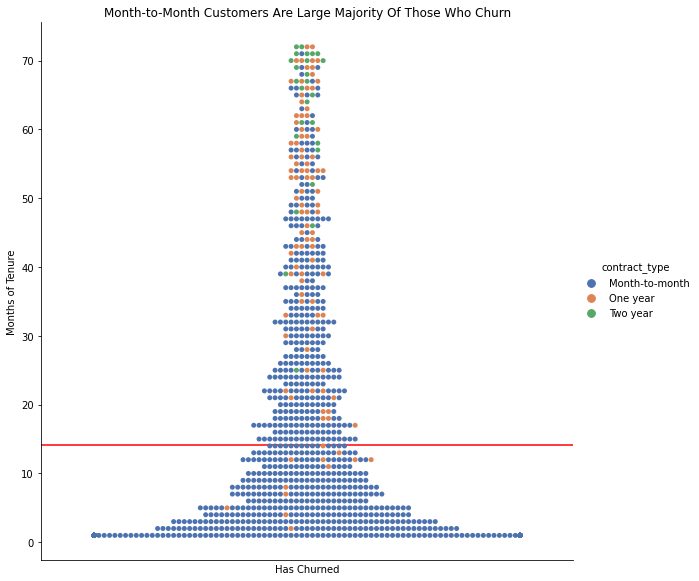

In [274]:

sns.catplot(x='churn', y='tenure', 
            kind='swarm', hue='contract_type', 
            palette='deep', size=8, aspect=1,
            data=train[train.churn==1])

plt.title('Month-to-Month Customers Are Large Majority Of Those Who Churn')
plt.xlabel('Has Churned')
plt.ylabel('Months of Tenure')
plt.xticks([1], ['Has Churned'])
plt.axhline(y=train.tenure[(train.churn==1) & (train.contract_type == 'Month-to-month')].mean(), 
            color='red')

**Red line indicates average tenure for month-to-month customers who churn**

([<matplotlib.axis.XTick at 0x7fb586840fd0>,
 [Text(0, 0, 'No'), Text(1, 0, 'Yes')])

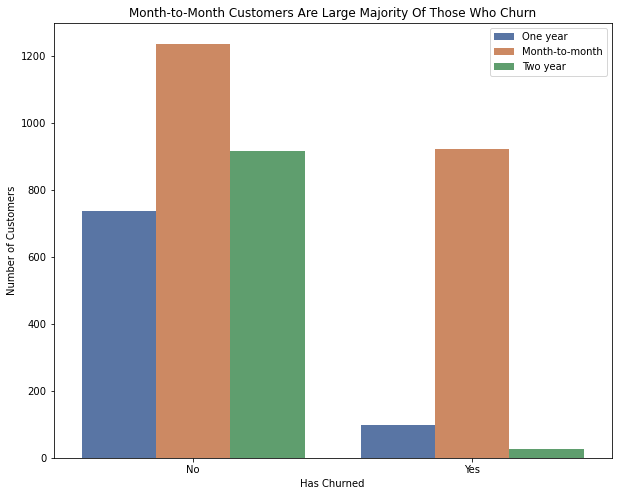

In [269]:
plt.figure(figsize=(10,8))
sns.countplot(x='churn', hue='contract_type', palette='deep', data=train)
plt.title('Month-to-Month Customers Are Large Majority Of Those Who Churn')
plt.legend(loc='upper right')
plt.xlabel('Has Churned')
plt.ylabel('Number of Customers')
plt.xticks([0,1], ['No','Yes'])

In [ ]:
plt.title("Some_title")
sns.barplot(x="species", y="petal_length", data=train)
mean_petal_length = train.petal_length.mean()
plt.axhline(mean_petal_length, label="Mean petal length", color='red', linestyle='dotted')
plt.xlabel('')
plt.legend()
plt.show()

### Do customers with month-to-month contracts churn at a higher rate? What are the churn rates with other contract types?

In [9]:
# viz

### Answer

### Is there a certain tenure length where month-to-month customers are more likely to churn? What about customers with contracts?

In [10]:
# viz

### Answer

### Is any specific service associated with higher churn rates?

In [11]:
# viz

### Answer

### Is it higher monthly charges that are causing churn? If so, what is that threshold where most customers churn for their specific service?

In [12]:
# viz

### Answer

2 statistical tests (state null/alternate hypothesis) include vizes of the variable interactions

correlation: 2 continuous variables, normally distributed, testing for LINEAR correlation only (H_0: Not linearly dependent) - independent t-test: 1 continuous, somewhat normally distributed variable, one boolean variable, equal variance, independent (H_0: population mean of each group is equal) - chi-square test: 2 discrete variables. (H_0: the 2 variables are independent of each other). (other tests may be used)

## Look at user defined functions to see which might be useful

## Analysis Summary
- What I found
- How I will use it moving forward
- This includes key takeaways from all the questions answered in explore
- a list of which features will be used in modeling and why
- which features will not move forward and why

## Modeling

3 best models

Create a baseline and evaluate performance. The baseline is based on the training dataset.

Evaluate on train

Evaluate 3 best on validate

Clear communication as to how you evaluated and compared models. What metric(s) did you use and why? For example, in one case, you may decide to use precision over accuracy. If so, why? If you use multiple metrics, how will you decide which to select if metric is better for model A but another is better for model B? Will you rank them? Find a way to aggregate them into a single metric you can use to rank?

Evaluate top model on Test

In [13]:
# comments in every code block

On your best model, a chart visualizing how it performed on test would be nice

# Conclusion

## Summary

- Original goals and how I reached them or didn't

the summary should tie together your analysis, the drivers of the outcome, and how you would expect your ML model to perform in the future on unseen data, in layman's terms.

"I expect this model to perform with x% accuracy on unseen data"

## Recommendations

actionable recommendations based on your insights and analysis to the business stakeholder(s),

## Next Steps

remember the best way to improve performance is to have better predictors/features. If you talk about gathering more data, being specific about what data you think will help you understand the problem better and why is the way to go!